# Hierarchical model for spelling performance

We analyze the data from the study `D. Thissen, Steinberg, and Wainer 1993` which can be found in the R [spelling](https://rdrr.io/cran/edstan/man/spelling.html) package

In [1]:
# usual imports

%matplotlib inline

import numpy as np
import pandas as pd
import scipy as sp
import pymc3 as pm
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')


# some standard routines

def summarize(alpha=0.05):

    def _summarize(ser):
        hpd_ = pm.hpd(ser, alpha=alpha)
        return pd.Series({
            'mean_': ser.mean(),
            'lower': hpd_[0],
            'upper': hpd_[1],
        })

    return _summarize


def agg_prediction(trace_var, source_data, group_columns, aggregate_fc):
    df = pd.DataFrame(trace_var).stack().reset_index().drop('level_0', axis=1)
    merged = pd.merge(
        df, source_data[group_columns],
        left_on='level_1', right_index=True
    )

    return (
        merged.groupby(group_columns)[0].apply(aggregate_fc)
        .unstack().sort_index().reset_index()
    )

### Loading the data

In [2]:
data = pd.read_csv('spelling.csv')

data = data.set_index('male', append=True)
words = data.columns.values

data.columns = np.arange(4)

data = data.stack().reset_index()
data.columns = ['person_i', 'male', 'word_i', 'correct']

n_person = data.person_i.nunique()

print(n_person)
data.sample(5)

658


,person_i,male,word_i,correct
608,152,0,0,1
1014,253,1,2,0
1269,317,0,1,1
105,26,0,1,0
542,135,1,2,1


Each row here has information about the person id (enumerated), whether the person is male, what is the word they need to spell (enumerated as in the chart below) and if they successfully spelled it.

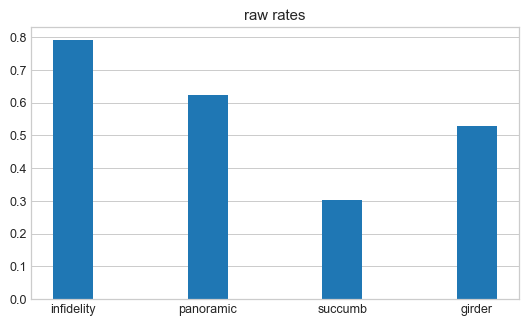

In [4]:
plt.figure(figsize=(7, 4), dpi=90)
plt.bar(range(4), data.groupby('word_i').correct.mean(), 0.3)

plt.grid(axis='x')
plt.gca().set(
    title='raw rates',
    xticks=range(4),
    xticklabels=words)
None

## Model

We model the rate of spelling success as a logistic combination of the individual capability of the person, as well as the word effect on the success - some words are easier to spell. Furthermore, we expect the word effect to have an interaction with the person's sex, so we use covariate effects. Both are done with a non-centered parametarization.

$$ \text{correct} \sim \text{Bernouilli}(p) $$


$$ logit({p}) = A_i + B_i  {is\_male}_i  $$



$$ A = a + {word\_a}_{word} + {person\_a}_{person} $$


$$ B = b\_male + {word\_male}_{word}   $$

$$ a \sim \text{Normal}(0, 1.5)   $$

$$ b\_male \sim \text{Normal}(0, 1)   $$

$$ person\_a \sim \text{Normal}(0, \bar{person}) $$

$$ \bar{person} \sim \text{Exponential}(1) $$ 

$$ {(word\_a, word\_male)} \sim \text{Normal}(0, \text{cholesky_covariance}=word\_chol) $$

$$ word\_chol \sim \text{LKJCholesky}(\eta=1, \sigma \sim \text{Exponential}(1) )$$

In [ ]:
with pm.Model() as m1:
    a = pm.Normal('a', mu=0, sd=1.5)
    b_male = pm.Normal('b_male', mu=0, sd=1)

    K_word = pm.LKJCholeskyCov(
        'K_word', n=2, eta=1,
        sd_dist = pm.Exponential.dist(lam=1, shape=2)
    )
    word = pm.MvNormal(
        'word', mu=0, 
        cov = pm.expand_packed_triangular(2, K_word),
        shape = (4, 2)
    )

    word_a = pm.Deterministic('word_a', word[:, 0])
    word_male = pm.Deterministic('word_male', word[:, 1])

    person_bar = pm.Exponential('person_bar', lam=1)
    person_a = pm.Normal('person_a', mu=0, sd=person_bar,
                         shape=n_person)

    p = pm.Deterministic(
        'p',
        pm.math.invlogit(
            a
            + person_a[data.person_i.values]
            + word_a[data.word_i.values]
            # gender effects
            + (b_male + word_male[data.word_i.values])
                * data.male.values
        )
    )

    # inference
    obs = pm.Binomial('obs', n=1, p=p,
                      observed=data.correct.values)

    # individual rates for an average word
    person_p = pm.Deterministic(
        'person_p',
        pm.math.invlogit(
            a
            + person_a[data.person_i.values]
            + b_male * data.male.values
        )
    )

    # word rates for an average individual
    word_p = pm.Deterministic(
        'word_p',
        pm.math.invlogit(
            a
            + word_a[data.word_i.values]
            + (b_male + word_male[data.word_i.values])
                * data.male.values
        )
    )

    m1.name = 'covariate'
    m1.trace = pm.sample(3000, tune=6000, chains=2)

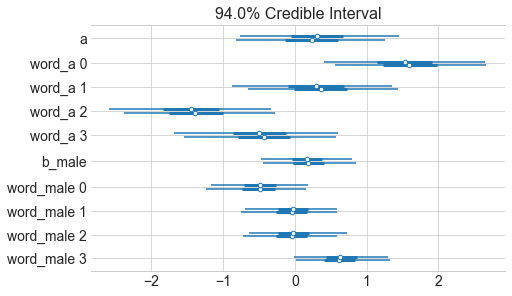

In [8]:
fig, axes = pm.plot_forest(m1.trace, var_names=['a', 'word_a', 'b_male', 'word_male'],
                           figsize=(7, 4))
axes[0].grid()
None

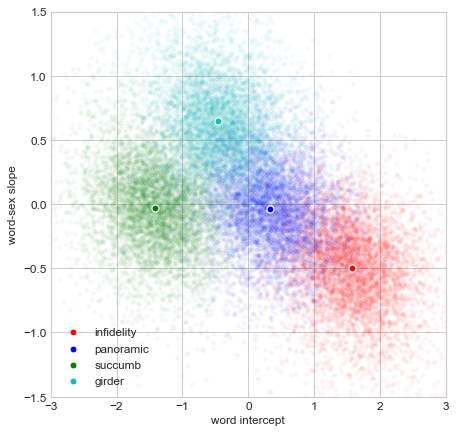

In [11]:
plt.figure(figsize=(6, 6), dpi=85)

for c, word_i in zip('rbgc', range(4)):
    _a = m1.trace['word_a'][:, word_i]
    _male = m1.trace['word_male'][:, word_i]

    plt.scatter(_a, _male,
                c=c, marker='.', alpha=.03, label='')
    
for label, c, _a, _male in zip(
        words, 'rbgcym',
        m1.trace['word_a'].mean(axis=0),
        m1.trace['word_male'].mean(axis=0)):
    plt.scatter(_a, _male, facecolor=c, edgecolor='white',
                marker='o', alpha=1, label=label)

plt.legend(loc='lower left')
plt.gca().set(xlabel='word intercept', ylabel='word-sex slope',
              xlim=(-3, 3), ylim=(-1.5, 1.5)
             )
None

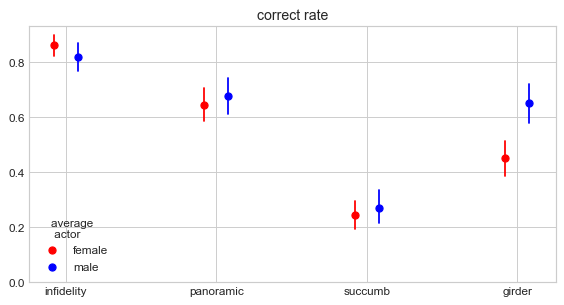

In [14]:
tmp = agg_prediction(m1.trace['word_p'], data, ['word_i', 'male'], summarize())

plt.figure(figsize=(8, 4), dpi=85)

_cur = tmp[tmp.male == 0]
plt.scatter(_cur.word_i - .08, _cur.mean_,
            c='r', label='female')
plt.plot((_cur.word_i - .08, _cur.word_i - .08),
         (_cur.lower, _cur.upper),
         c='r')

_cur = tmp[tmp.male == 1]
plt.scatter(_cur.word_i + .08, _cur.mean_,
            c='b', label='male')
plt.plot((_cur.word_i + .08, _cur.word_i + .08),
         (_cur.lower, _cur.upper),
         c='b')

plt.gca().set(xticks=range(4), xticklabels=words,
              title='correct rate', ylim=(0, None))
plt.legend(title='average \n actor')
None

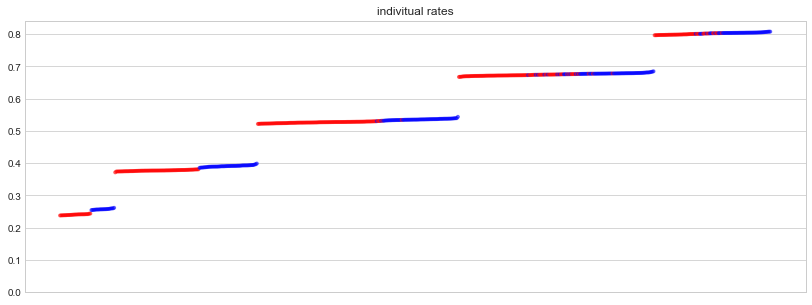

In [15]:
tmp = agg_prediction(m1.trace['person_p'], data, ['person_i'], summarize())
tmp = tmp.merge(data[['person_i', 'male']].drop_duplicates())
tmp = tmp.sort_values('mean_').reset_index(drop=True)

plt.figure(figsize=(14, 5))
c = tmp.male.map(lambda male: 'r' if male==0 else 'b')
plt.scatter(tmp.index, tmp.mean_, marker='.', c=c, alpha=.5)
plt.gca().set(ylim=(0, None), xticks=[], title='indivitual rates')
None